In [1]:
climatology_file = 'data/river_climatology.xlsx'
fraser_file = 'data/fraser_climatology.xlsx'
conditions_file = 'data/quantile_years.xlsx'

control_year = 2014
period_bounds = (f'{control_year}.01.01',f'{control_year}.12.31')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patheffects as pe
from scipy.signal import find_peaks
from scipy.interpolate import interp1d
from adjustText import adjust_text

In [2]:
climatology_df = pd.read_excel(climatology_file, index_col=0)
climatology_df.head()

,12200500,12150800,12101500,12167000,12113000,12089500,12205000,12060500,12119000,12054000,12048000,12059500
Date,,,,,,,,,,,,
1945-09-02,188.0448,36.558314,38.2320,7.44816,4.64448,11.219983,12.60240,2.26560,3.96480,2.29392,3.99312,0.192576
1945-09-03,173.3184,38.465705,37.6656,7.70304,4.72944,11.517272,16.22736,2.94528,4.13472,3.05856,3.99312,0.271872
1945-09-04,227.1264,158.242752,71.3664,73.91520,8.69424,17.363946,59.47200,27.49872,7.47648,16.87872,9.43056,1.246080
1945-09-05,470.1120,256.438031,98.5536,70.23360,14.86800,19.098129,23.22240,12.71568,8.46768,8.26944,6.99504,0.566400
1945-09-06,334.1760,158.242752,70.5168,30.01920,9.51552,15.134282,15.32112,7.30656,6.20208,5.40912,5.40912,0.396480


I have shown elsewhere (in the full WYMultipliers notebook) that the North Fork Skokomish does not follow the same interannual patterns as all other streams, and so the way I deal with this problem is to drop it from the climatology analysis.

In [3]:
incl_streams = climatology_df.drop(columns=[12059500])

Load the representative quantile years (from 

In [4]:
conditions_df = pd.read_excel(conditions_file)
conditions_df.head()

,0.1,0.2,0.3,0.5,0.7,0.8,0.9
0,1992,1970,1953,2008,1960,1971,1996
1,2019,1987,1986,1981,2017,2002,2022
2,1993,1952,1963,1965,1990,1964,1959
3,2003,1966,1980,1955,2007,1951,1956
4,1979,2005,1995,1949,1982,1999,1950


In [5]:
def calc_multiples(like_streams, q, control_year):
    daily_avg = like_streams.mean(axis=1)
    no_leapday_indexer = ~((daily_avg.index.month == 2) & (daily_avg.index.day == 29))
    daily_avg_comp = daily_avg.loc[no_leapday_indexer]
    monthly_mean = daily_avg_comp.resample('ME').mean()
    monthly_q = monthly_mean.groupby(monthly_mean.index.month).quantile(q)

    daily_avg_control = daily_avg.loc[(daily_avg.index.to_period('Y').year == control_year) & no_leapday_indexer]
    monthly_avg_control = daily_avg_control.groupby(daily_avg_control.index.month).mean()

    multiples = monthly_q / monthly_avg_control
    return monthly_q, monthly_avg_control, multiples

calc_multiples(incl_streams, 0.5, control_year)

(Date
 1     120.137277
 2     102.559777
 3      88.019135
 4      96.970898
 5     118.547537
 6     120.766135
 7      78.527664
 8      47.368877
 9      40.808464
 10     67.590372
 11    115.572737
 12    115.998595
 dtype: float64,
 Date
 1     108.286246
 2      88.936661
 3     189.571173
 4     123.303649
 5     152.256708
 6     117.775585
 7      95.863333
 8      49.512446
 9      40.597595
 10     89.346660
 11    177.449258
 12    150.211190
 dtype: float64,
 Date
 1     1.109442
 2     1.153178
 3     0.464307
 4     0.786440
 5     0.778603
 6     1.025392
 7     0.819163
 8     0.956706
 9     1.005194
 10    0.756496
 11    0.651300
 12    0.772237
 dtype: float64)

In [6]:
multiples = calc_multiples(incl_streams, 0.5, control_year)[2]
outer_bounds = (pd.Timestamp(period_bounds[0]) - pd.Timedelta(17, 'D'),
                pd.Timestamp(period_bounds[1]) + pd.Timedelta(15, 'D'))
daily_index = pd.period_range(start=period_bounds[0], end=period_bounds[1]).to_timestamp()
daily_index_outer = pd.period_range(start=outer_bounds[0], end=outer_bounds[1]).to_timestamp()
with pd.ExcelWriter('stream_multipliers_simplemedian_2014.xlsx') as writer:
    data = {
        'Rain-dominated': multiples,
        'Rain-snow Mix': multiples,
        'Snow': multiples
    }
    df = pd.DataFrame(data)
    ymd = {'year': control_year, 'month': df.index, 'day': np.where(df.index.values == 2, 14, 15)}
    df.set_index(pd.to_datetime(ymd), inplace=True)
    df.loc[outer_bounds[0]] = df.iloc[-1]
    df.loc[outer_bounds[1]] = df.iloc[0]
    df.sort_index(inplace=True)
    daily_df = df.reindex(daily_index_outer)
    for c in df.columns:
        i = interp1d((df.index - pd.Timestamp(period_bounds[0])).days, df[c])
        daily_df[c] = i((daily_df.index - pd.Timestamp(period_bounds[0])).days)
    daily_df_period = daily_df.reindex(daily_index)
    daily_df_period.index.name = 'Date'
    daily_df_period.to_excel(writer, sheet_name='q=0.5')

In [7]:
cal_year_totals = climatology_df.groupby(climatology_df.index.to_period('Y')).sum().sum(axis=1) * 86400
# Drop the first and last years as they're incomplete
cal_year_totals.drop(cal_year_totals.index[0], inplace=True)
cal_year_totals.drop(cal_year_totals.index[-1], inplace=True)

totals = pd.DataFrame({'Total': cal_year_totals})

In [8]:
def calc_multiple(totals, q):
    # Reindex the series with ints rather than Periods
    totals_yr = pd.Series(totals.array, index=totals.index.year) if totals.index.dtype != np.int64 else totals
    target_avg = totals_yr.quantile(q)
    control_total = totals_yr.median()
    return target_avg / control_total, target_avg

calc_multiple(cal_year_totals, 0.9)

(1.2220927013661174, 41150245561.6745)

<BarContainer object of 7 artists>

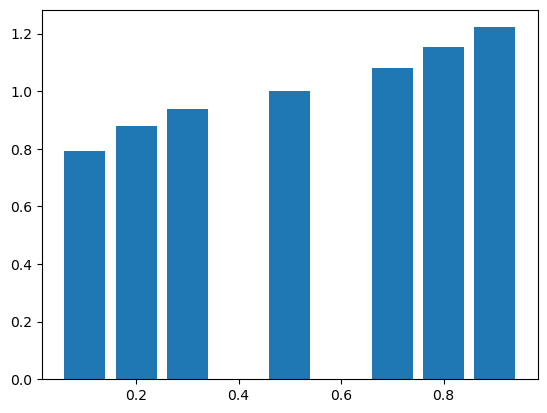

In [9]:
fig, ax = plt.subplots()
qs = sorted(conditions_df.columns)
multipliers = np.array([calc_multiple(cal_year_totals, c) for c in qs])
ax.bar(qs, multipliers[:,0], 0.08)

In [10]:
pd.DataFrame(multipliers, index=qs)

,0,1
0.1,0.792171,2.667395e+10
0.2,0.881011,2.966536e+10
0.3,0.939313,3.162850e+10
0.5,1.000000,3.367195e+10
0.7,1.079162,3.633749e+10
0.8,1.153471,3.883961e+10
0.9,1.222093,4.115025e+10
